In [1]:
!git clone https://github.com/ahmedbadr97/Bike-Sharing-Demand-autoGluon

Cloning into 'Bike-Sharing-Demand-autoGluon'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 2), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [2]:
%cd /content/Bike-Sharing-Demand-autoGluon

/content/Bike-Sharing-Demand-autoGluon


In [7]:
import config
#- config data --> git_username, email ,git_token, repository_name, kaggle_username, kaggle_key 
!git config --global user.name {config.git_username}
!git config --global user.email {config.email}
!git remote remove origin
!git remote add origin https://{config.git_token}@github.com/{config.username}/{config.repository}.git

# Predict Bike Sharing Demand with AutoGluon

### Install packages

In [8]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.0

!pip install autogluon 
!pip install kaggle
# Without --no-cache-dir, smaller aws instances may have trouble installing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 28.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.9 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━

In [46]:
import pandas as pd
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import random
import math

### Setup Kaggle API Key

In [9]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [10]:
# Fill in your user name and key from creating the kaggle account and API token file
import json

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": config.kaggle_username, "key": config.kaggle_key}))

In [48]:
def model_inference(predictor,data,output_label):  
  predictions=predictor.predict(data)
  actual_values=train[output_label]

  actual_predicted_pairs=list(zip(actual_values,predictions))
  squared_error_sum=0.0
  for actual_value,train_perdiction in actual_predicted_pairs:
    squared_error_sum+=(train_perdiction-actual_value)**2
  rmse=math.sqrt(float(squared_error_sum)/len(actual_predicted_pairs))
  print(f"root mean squared error = {round(rmse,4)}")
  return actual_predicted_pairs,rmse



In [41]:
def plot_infrences(actual_predicted_pairs,sample_size=100):
  data_pairs_sample=random.sample(actual_predicted_pairs,sample_size)
  actual_data_sample=[ pair[0] for pair in data_pairs_sample]
  train_pred_sample=[ pair[1] for pair in data_pairs_sample]
  fig = plt.figure(figsize=(25,12))
  ax = fig.add_subplot(1, 1, 1)
  ax.plot(actual_data_sample, color='tab:blue',label="actual values")
  ax.plot(train_pred_sample, color='tab:orange',label="predicted values")
  plt.legend()

### Download and explore dataset

In [11]:
dataset_path="/content/Bike-Sharing-Demand-autoGluon/dataset"

In [12]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!mkdir {dataset_path}
!unzip -o bike-sharing-demand.zip -d {dataset_path}

100% 189k/189k [00:00<00:00, 284kB/s]
100% 189k/189k [00:00<00:00, 284kB/s]
Archive:  bike-sharing-demand.zip
  inflating: /content/Bike-Sharing-Demand-autoGluon/dataset/sampleSubmission.csv  
  inflating: /content/Bike-Sharing-Demand-autoGluon/dataset/test.csv  
  inflating: /content/Bike-Sharing-Demand-autoGluon/dataset/train.csv  


In [14]:

# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv(f"{dataset_path}/train.csv")
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [16]:
train['datetime']=pd.to_datetime(train['datetime'])


In [17]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec475b2c90>,
      dtype=object)

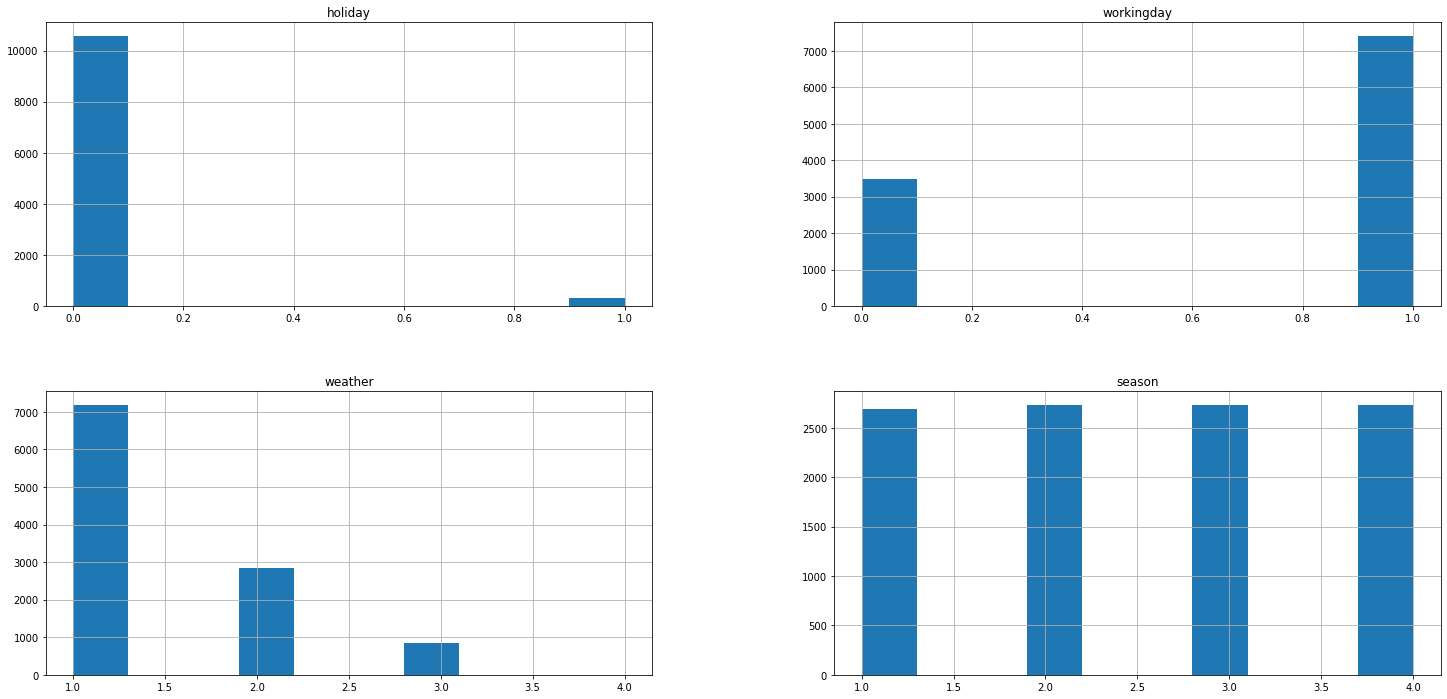

In [ ]:
train.hist(column =['holiday','workingday','weather','season'],figsize=(25,12))

In [ ]:
train.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


In [17]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv(f"{dataset_path}/test.csv")
test['datetime']=pd.to_datetime(test['datetime'])

test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [18]:
# Same thing as train and test dataset
submission = pd.read_csv(f"{dataset_path}/sampleSubmission.csv")
submission['datetime']=pd.to_datetime(submission['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


##  Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [19]:
train.drop(columns=['casual','registered'],inplace=True)

In [ ]:
predictor = TabularPredictor(label='count',eval_metric="root_mean_squared_error").fit(train_data=train,time_limit=600,presets="best_quality")

Level 25:autogluon.common.utils.utils:No path specified. Models will be saved in: "AutogluonModels/ag-20221102_132644/"
INFO:autogluon.tabular.predictor.predictor:Presets specified: ['best_quality']
INFO:autogluon.tabular.predictor.predictor:Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
INFO:autogluon.tabular.learner.default_learner:Beginning AutoGluon training ... Time limit = 600s
INFO:autogluon.tabular.learner.default_learner:AutoGluon will save models to "AutogluonModels/ag-20221102_132644/"
INFO:autogluon.tabular.learner.default_learner:AutoGluon Version:  0.5.2
INFO:autogluon.tabular.learner.default_learner:Python Version:     3.7.15
INFO:autogluon.tabular.learner.default_learner:Operating System:   Linux
INFO:autogluon.tabular.learner.default_learner:Train Data Rows:    10886
INFO:autogluon.tabular.learner.default_learner:Train Data Columns: 9
INFO:autogluon.tabular.learner.default_learner:Label Column: count
INFO:autogluon.tabular.l

### Review AutoGluon's training run with ranking of models that did the best.

In [ ]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.724409      12.262843  518.978705                0.000669           0.308228            3       True         16
1   RandomForestMSE_BAG_L2  -53.319035      11.391583  421.058132                0.593940          31.199960            2       True         13
2     ExtraTreesMSE_BAG_L2  -53.651554      11.376920  397.811157                0.579278           7.952985            2       True         15
3          LightGBM_BAG_L2  -55.069419      10.996727  410.350243                0.199084          20.492071            2       True         12
4          CatBoost_BAG_L2  -55.459653      10.889872  459.025461                0.092229          69.167289            2       True         14
5        LightGBMXT_BAG_L2  -60.260483      14.072636  439.906692         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_

## evaluation on train data
- evaluate the model on train data before submission 

In [ ]:
actual_predicted_pairs,rmse=model_inference(predictor,train,output_label="count")

root mean squared error = 71.4868


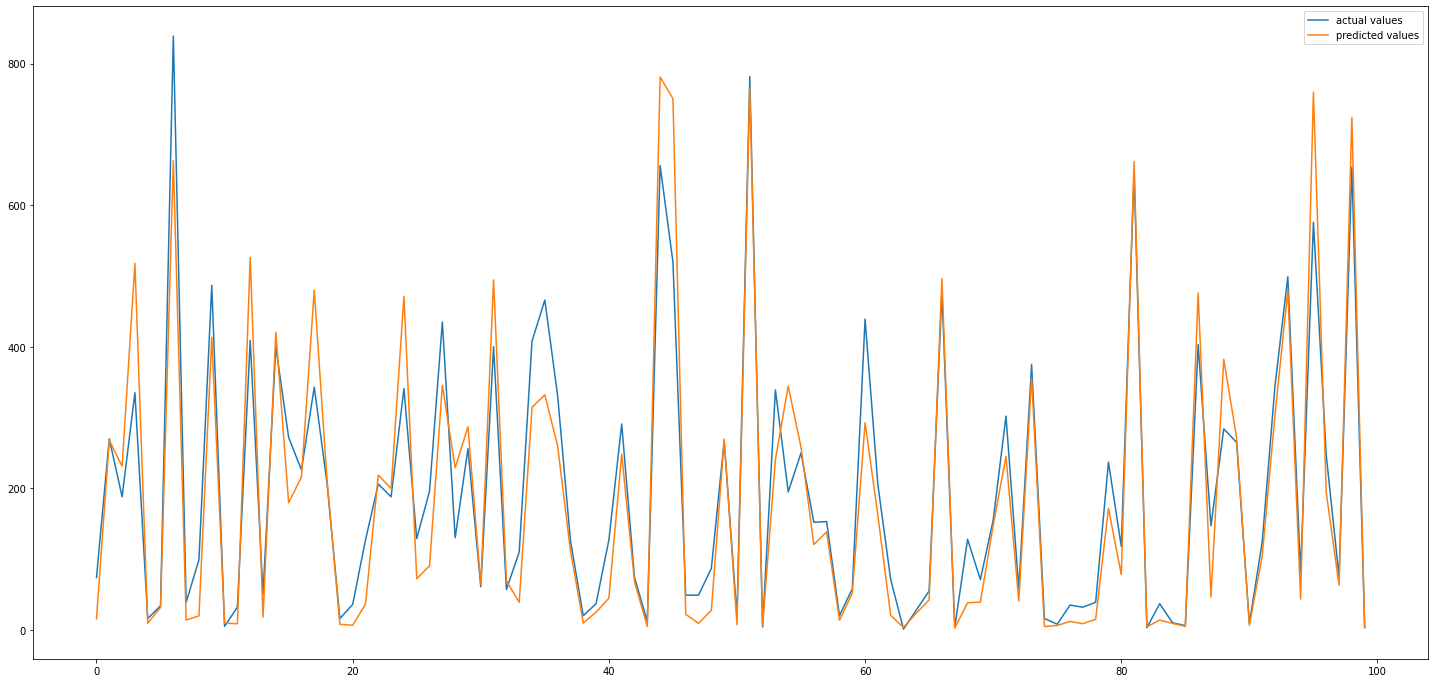

In [ ]:
plot_infrences(actual_predicted_pairs,sample_size=100)

## Create predictions from test dataset

In [ ]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
predictions=predictor.predict(test)

In [ ]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.720047
std        90.255417
min         3.063603
25%        20.568230
50%        62.858883
75%       169.303329
max       362.679077
Name: count, dtype: float64

In [ ]:
# check for negative values as kaggle won't accept negative value
predictions[predictions<0].count()

0

- no values less than zero

### Set predictions to submission dataframe, save, and submit

In [ ]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:01<00:00, 181kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2022-11-02 13:50:57  first raw submission  complete  1.79789      1.79789       
submission.csv  2022-10-31 21:58:41  first raw submission  complete  1.80666      1.80666       


#### Initial score of 1.79789

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec45b412d0>,
      dtype=object)

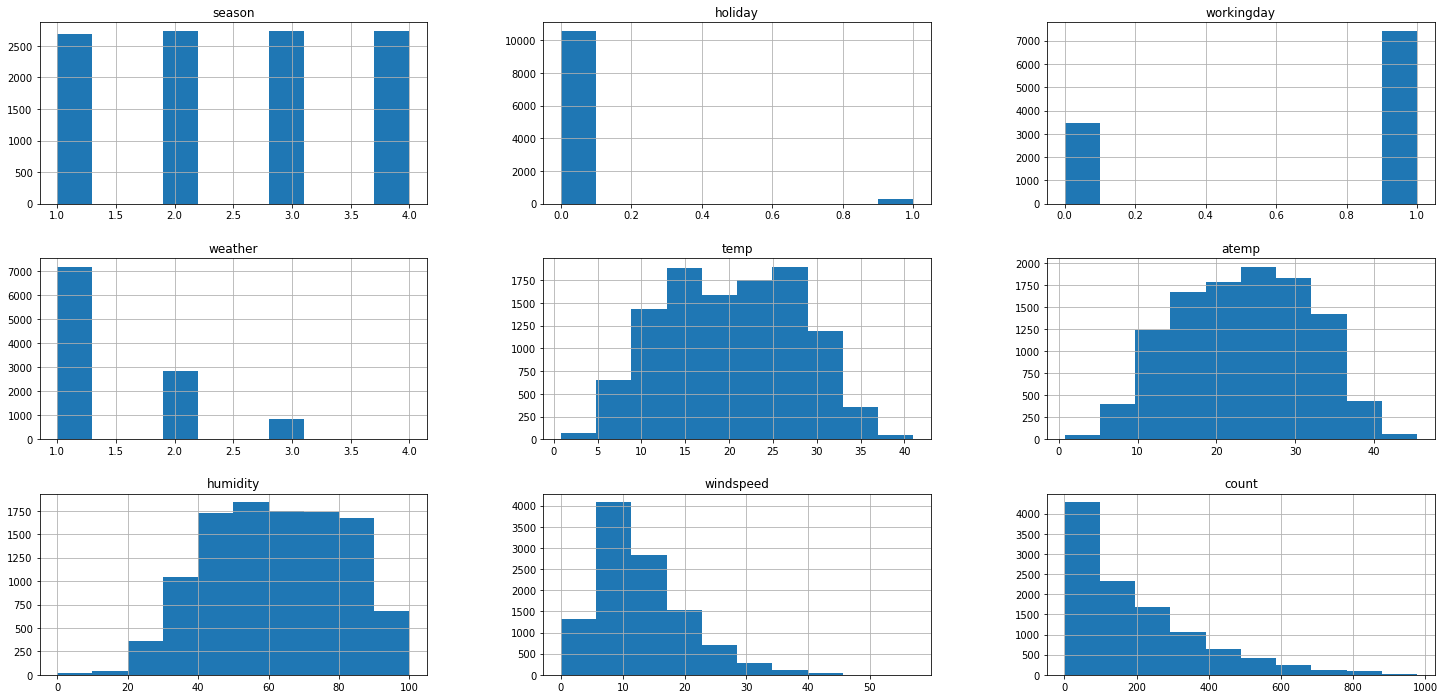

In [ ]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(25,12))

In [ ]:
train.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000


- correlation table comment
    - there is a strong direct relation between temp and atemp so we can drop one of them

In [20]:
# add new features

train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour

train.drop(columns='datetime',inplace=True)


test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour

test.drop(columns='datetime',inplace=True)


In [ ]:
# we can drop the temp column 
# train.drop(columns=['temp'],inplace=True)
# test.drop(columns=['temp'],inplace=True)

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [21]:
train["season"] = train["season"].astype('category')
train["weather"] = train["season"].astype('category')
test["season"] = test["season"].astype('category')
train["weather"] = test["season"].astype('category')

In [23]:
# View are new feature
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,1,1,4


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab0303e650>,
      dtype=object)

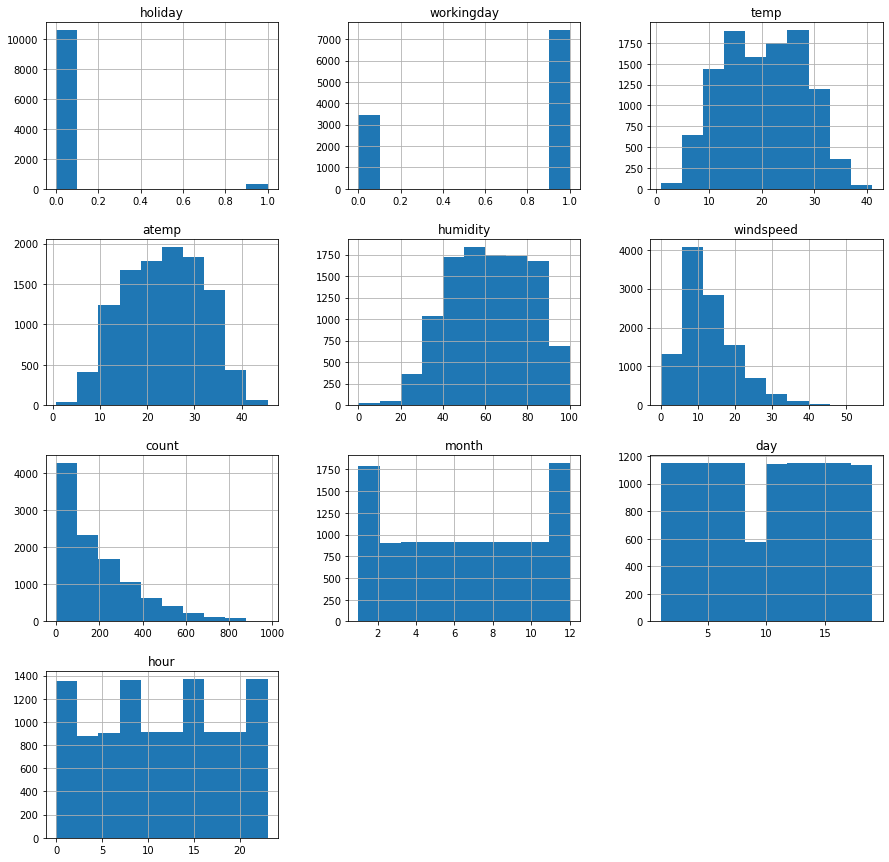

In [24]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(15,15))

## Step 5: Rerun the model with the same settings as before, just with more features

In [25]:
predictor_new_features = TabularPredictor(label='count',eval_metric="root_mean_squared_error").fit(train_data=train,time_limit=600,presets="best_quality")

Level 25:autogluon.common.utils.utils:No path specified. Models will be saved in: "AutogluonModels/ag-20221103_112725/"
INFO:autogluon.tabular.predictor.predictor:Presets specified: ['best_quality']
INFO:autogluon.tabular.predictor.predictor:Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
INFO:autogluon.tabular.learner.default_learner:Beginning AutoGluon training ... Time limit = 600s
INFO:autogluon.tabular.learner.default_learner:AutoGluon will save models to "AutogluonModels/ag-20221103_112725/"
INFO:autogluon.tabular.learner.default_learner:AutoGluon Version:  0.5.2
INFO:autogluon.tabular.learner.default_learner:Python Version:     3.7.15
INFO:autogluon.tabular.learner.default_learner:Operating System:   Linux
INFO:autogluon.tabular.learner.default_learner:Train Data Rows:    10886
INFO:autogluon.tabular.learner.default_learner:Train Data Columns: 11
INFO:autogluon.tabular.learner.default_learner:Label Column: count
INFO:autogluon.tabular.

In [ ]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -37.951849      26.236663  561.414250                0.001184           0.568368            3       True         16
1     ExtraTreesMSE_BAG_L2  -38.160196      24.866984  405.544179                0.576667           7.519746            2       True         14
2      WeightedEnsemble_L2  -38.344141      23.464668  359.969972                0.000927           0.686252            2       True          9
3          CatBoost_BAG_L2  -38.466954      24.385254  454.668566                0.094938          56.644133            2       True         13
4          LightGBM_BAG_L2  -38.571496      24.430917  417.096317                0.140600          19.071884            2       True         11
5   NeuralNetFastAI_BAG_L2  -38.732838      24.788316  443.971027         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -123.93326033133259,
  'KNeighborsDist_BAG_L1': -119.3656013058328

In [ ]:
actual_predicted_pairs,rmse=model_inference(predictor_new_features,train,output_label="count")

root mean squared error = 19.254


- the mean squared error decreased after adding the month , day , hour feature coloumns and removing the datetime , becuase it's a unique value it won't happen again we must remove the year column
- also removing the temp col will decrease the trainnig time as it has strong correlation with the atemp

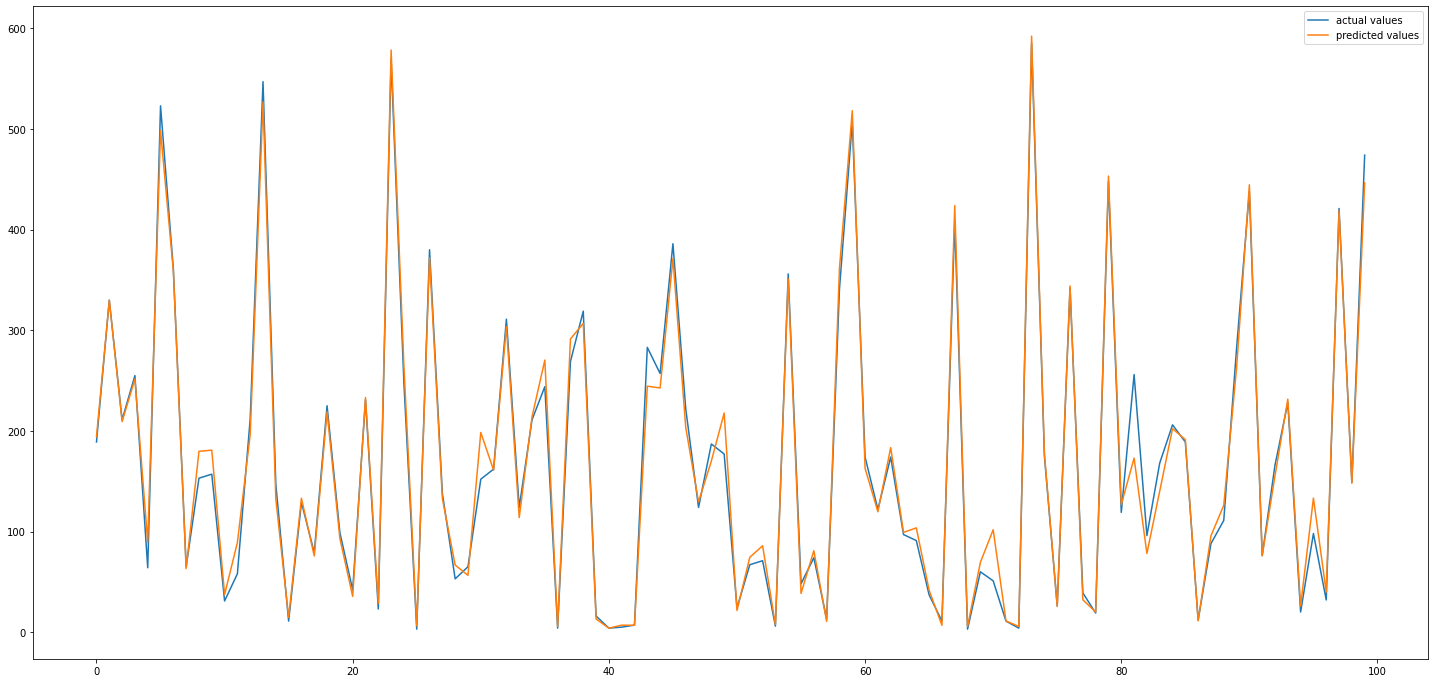

In [ ]:
plot_infrences(actual_predicted_pairs,sample_size=100)

In [ ]:
 # Remember to set all negative values to zero
test_predictions=predictor_new_features.predict(test)

In [ ]:
submission_new_features=submission.copy()

In [ ]:
# Same submitting predictions
submission_new_features["count"] = test_predictions
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features v2"

100% 188k/188k [00:01<00:00, 146kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2022-11-02 16:04:31  new features v2       complete  0.53702      0.53702       
submission_new_features.csv  2022-11-02 15:19:05  new features          complete  0.75812      0.75812       
submission.csv               2022-11-02 13:50:57  first raw submission  complete  1.79789      1.79789       
submission.csv               2022-10-31 21:58:41  first raw submission  complete  1.80666      1.80666       


#### New Score of `?`

## Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [30]:
train.describe()


,holiday,workingday,temp,atemp,humidity,windspeed,count,month,day,hour
count,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,0.680875,20.23086,23.655084,61.886460,12.799395,191.574132,6.521495,9.992559,11.541613
std,0.166599,0.466159,7.79159,8.474601,19.245033,8.164537,181.144454,3.444373,5.476608,6.915838
min,0.000000,0.000000,0.82000,0.760000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,13.94000,16.665000,47.000000,7.001500,42.000000,4.000000,5.000000,6.000000
50%,0.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000,7.000000,10.000000,12.000000
75%,0.000000,1.000000,26.24000,31.060000,77.000000,16.997900,284.000000,10.000000,15.000000,18.000000
max,1.000000,1.000000,41.00000,45.455000,100.000000,56.996900,977.000000,12.000000,19.000000,23.000000


In [32]:
no_leaves=0.005*train.count().max()
no_leaves

54.43

In [58]:
import autogluon.core as ag

# hyperparameter values for neural network models
nn_options = {   
    'num_epochs': 50,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-1, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'layers': ag.space.Categorical([128,256,512], [32,64,128], [16,32], [1]),  # each choice for categorical hyperparameter 'layers' corresponds to list of sizes for each NN layer to use
    'dropout_prob': ag.space.Real(0.3, 0.6, default=0.5),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 80,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=20, upper=60, default=50),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

#num_trials = 5  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using Bayesian optimization routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    #'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

predictor_new_hpo = TabularPredictor(label="count", eval_metric="root_mean_squared_error").fit(train_data=train, time_limit=600, presets="best_quality", hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
)

Level 25:autogluon.common.utils.utils:No path specified. Models will be saved in: "AutogluonModels/ag-20221103_152441/"
INFO:autogluon.tabular.predictor.predictor:Presets specified: ['best_quality']
INFO:autogluon.tabular.predictor.predictor:Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
INFO:autogluon.tabular.learner.default_learner:Beginning AutoGluon training ... Time limit = 600s
INFO:autogluon.tabular.learner.default_learner:AutoGluon will save models to "AutogluonModels/ag-20221103_152441/"
INFO:autogluon.tabular.learner.default_learner:AutoGluon Version:  0.5.2
INFO:autogluon.tabular.learner.default_learner:Python Version:     3.7.15
INFO:autogluon.tabular.learner.default_learner:Operating System:   Linux
INFO:autogluon.tabular.learner.default_learner:Train Data Rows:    10886
INFO:autogluon.tabular.learner.default_learner:Train Data Columns: 11
INFO:autogluon.tabular.learner.default_learner:Label Column: count
INFO:autogluon.tabular.

In [34]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                       model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        LightGBM_BAG_L1/T60  -40.211816       0.028856    0.332668                0.028856           0.332668            1       True         60
1        LightGBM_BAG_L1/T39  -41.661025       0.026802    0.278376                0.026802           0.278376            1       True         39
2        LightGBM_BAG_L1/T36  -41.903852       0.027557    0.288486                0.027557           0.288486            1       True         36
3        LightGBM_BAG_L1/T61  -41.982801       0.028392    0.297155                0.028392           0.297155            1       True         61
4        LightGBM_BAG_L1/T55  -42.186021       0.026075    0.282601                0.026075           0.282601            1       True         55
5        WeightedEnsemble_L2  -42.653143       0.299110   41.7

{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T5': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T6': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T7': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T8': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T9': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T10': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T11': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T12': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T13': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T14': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T15': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T16': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T17': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T18': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T19': 'StackerEnsembl

In [62]:
actual_predicted_pairs,rmse=model_inference(predictor_new_hpo,train,output_label="count")

root mean squared error = 30.1864


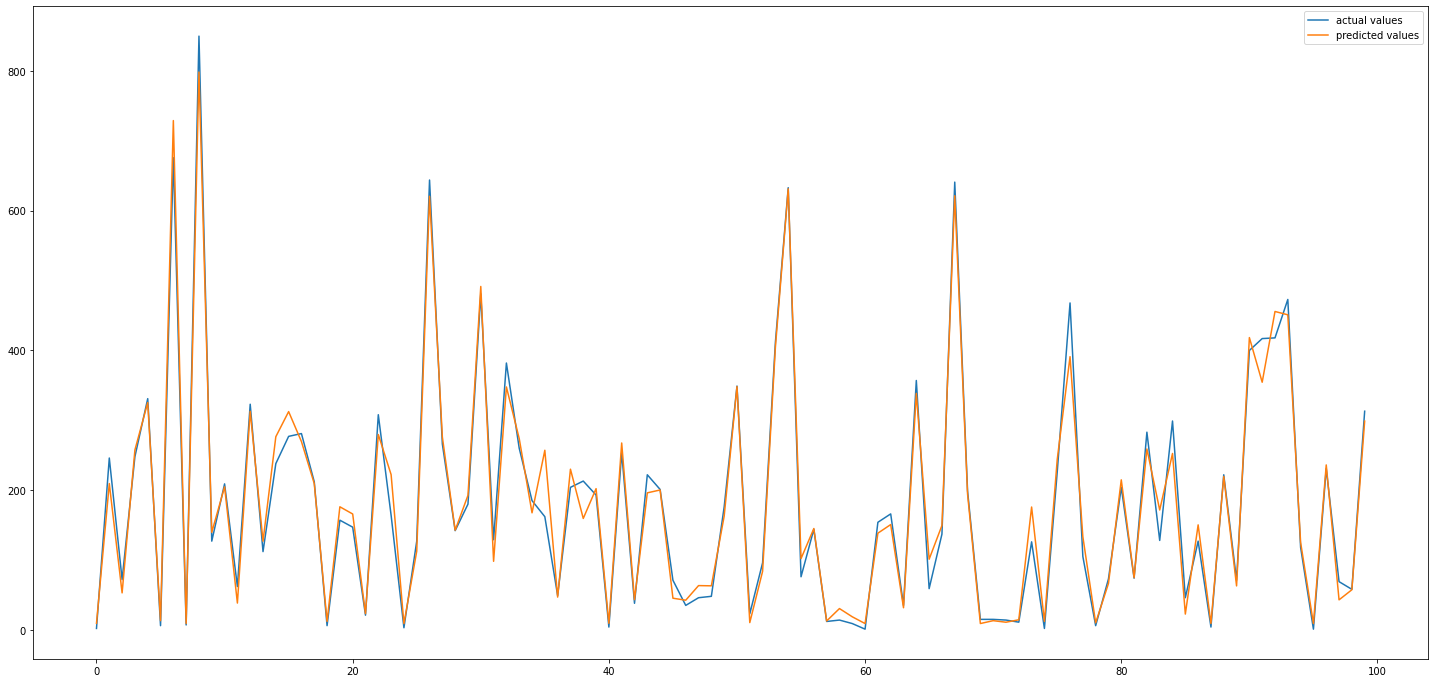

In [63]:
plot_infrences(actual_predicted_pairs,sample_size=100)


In [64]:
# Remember to set all negative values to zero
test_predictions=predictor_new_hpo.predict(test)


In [65]:
test_predictions[test_predictions<0].count()

0

In [66]:
# Same submitting predictions
submission_new_hpo=submission.copy()
submission_new_hpo["count"] = test_predictions
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [67]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100% 188k/188k [00:04<00:00, 44.3kB/s]
Successfully submitted to Bike Sharing Demand

In [68]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2022-11-03 15:44:08  new features with hyperparameters  complete  0.55460      0.55460       
submission_new_hpo.csv       2022-11-03 15:21:20  new features with hyperparameters  error                                
submission_new_features.csv  2022-11-02 16:04:31  new features v2                    complete  0.53702      0.53702       
submission_new_features.csv  2022-11-02 15:19:05  new features                       complete  0.75812      0.75812       


#### New Score of `?`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

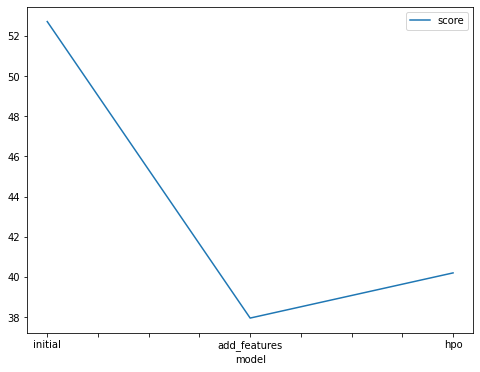

In [70]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [52.72, 37.95, 40.2]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

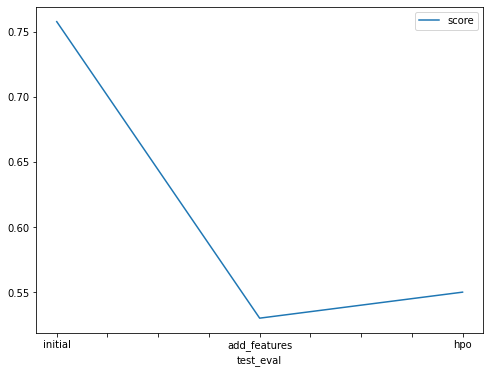

In [73]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [0.758, 0.53, 0.55]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [72]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "time_limit": [600, 600, 600],
    "presets": ["best_quality", "best_quality", "best_quality"],
    "model_hyperparameters": ["none","none", "nn:changed the nn activation functions to relu to make output postive only"],
    "score": [0.758, 0.53, 0.55]
})

,model,time_limit,presets,model_hyperparameters,score
0,initial,600,best_quality,none,0.758
1,add_features,600,best_quality,none,0.530
2,hpo,600,best_quality,nn:changed the nn activation functions to relu...,0.550
